In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from rl_algos.ppo_continuous import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
smoothness_baseline_scale = 1.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

num_envs = 256
num_updates = 4000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [4]:
single_train = jit(PPO_make_train(config), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    smoothness_baseline_scale,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    # batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 4000 Updates
global update: 100
reward: -191.77704931975686
max pF: 2.384938116772288
max photon: 24.65880297869444
photon time: 0.7428197447861723
smoothness: 0.005087343660085116
global update: 200
reward: -151.02544544909045
max pF: 2.560616818579245
max photon: 41.13502574712038
photon time: 0.8187370920671759
smoothness: 0.004074422136902968
global update: 300
reward: -116.43323310158956
max pF: 2.5609737962994705
max photon: 40.25551715493202
photon time: 0.8063498028204753
smoothness: 0.003291552399329601
global update: 400
reward: -77.57532008474683
max pF: 2.5628982642204834
max photon: 39.89603418111801
photon time: 0.7655321109183897
smoothness: 0.0024104002959961356
global update: 500
reward: -45.02314035723498
max pF: 2.562996016521817
max photon: 40.41325229406357
photon time: 0.7308153259004999
smoothness: 0.001653353209123773
global update: 600
reward: -25.971473368158975
max pF: 2.5637527180491846
max photon: 40.337393552064896
photon time: 0.67275766

In [5]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]
actions = metrics["action"]

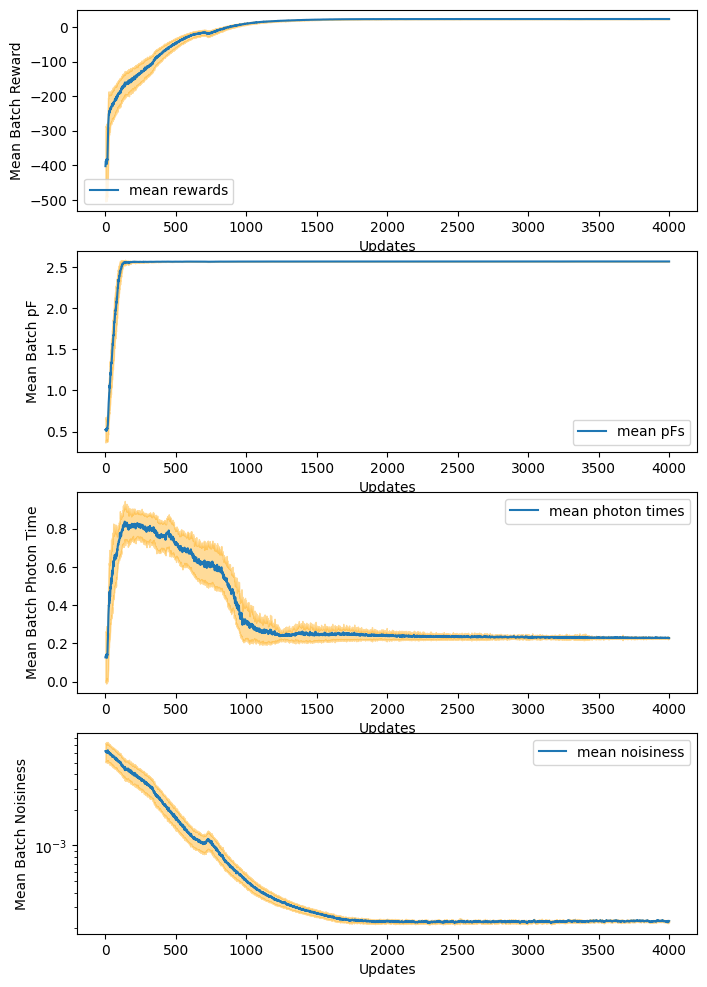

In [6]:
from utils import plot_learning

plot_learning(
    rewards=rewards,
    max_pFs=max_pFs,
    photon_times=photon_times,
    smoothnesses=smoothnesses,
)

In [7]:
from envs.single_photon_env import SinglePhotonLangevinReadoutEnv

env = SinglePhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    smoothness_baseline_scale=smoothness_baseline_scale,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

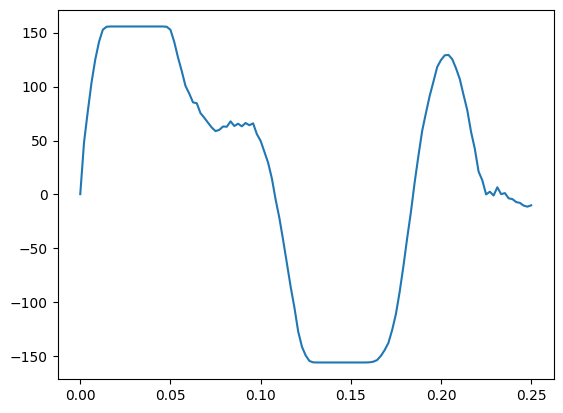

In [9]:
smooth_action = env.prepare_action(-jnp.mean(actions, axis=1)[-1])

plt.plot(env.ts_action, smooth_action)
plt.show()

## Increasing Smoothness Baseline (pulses can be noisier)

In [10]:
single_train_2 = jit(PPO_make_train(config), static_argnums=(-2, -1))

smoothness_baseline_scale_2 = 2.0

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_2 = single_train_2(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    smoothness_baseline_scale_2,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    # batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 4000 Updates
global update: 100
reward: -80.57670174092797
max pF: 2.5306148319992046
max photon: 32.13765247911215
photon time: 0.8251936722807175
smoothness: 0.004937421657052691
global update: 200
reward: -61.61539522893348
max pF: 2.557004856837686
max photon: 38.28380336612463
photon time: 0.8312540721682319
smoothness: 0.004017542525419209
global update: 300
reward: -37.309130118856366
max pF: 2.558004179481574
max photon: 37.824289843440056
photon time: 0.7329056376396405
smoothness: 0.002919066621579413
global update: 400
reward: -22.479166745880377
max pF: 2.5577271688633765
max photon: 37.6935967579484
photon time: 0.6771365656026285
smoothness: 0.0022626217045276656
global update: 500
reward: -7.684252820157245
max pF: 2.549100727162358
max photon: 33.98857981711626
photon time: 0.6427167432054202
smoothness: 0.001615099097082017
global update: 600
reward: 2.7195174501983295
max pF: 2.557171477256785
max photon: 37.916612312197685
photon time: 0.60477706364

In [12]:
# Extracting Results

metrics_2 = single_result_2["metrics"]

rewards_2 = metrics_2["reward"]
max_pFs_2 = metrics_2["max pF"]
max_photons_2 = metrics_2["max photon"]
photon_times_2 = metrics_2["photon time"]
smoothnesses_2 = metrics_2["smoothness"]
actions_2 = metrics_2["action"]

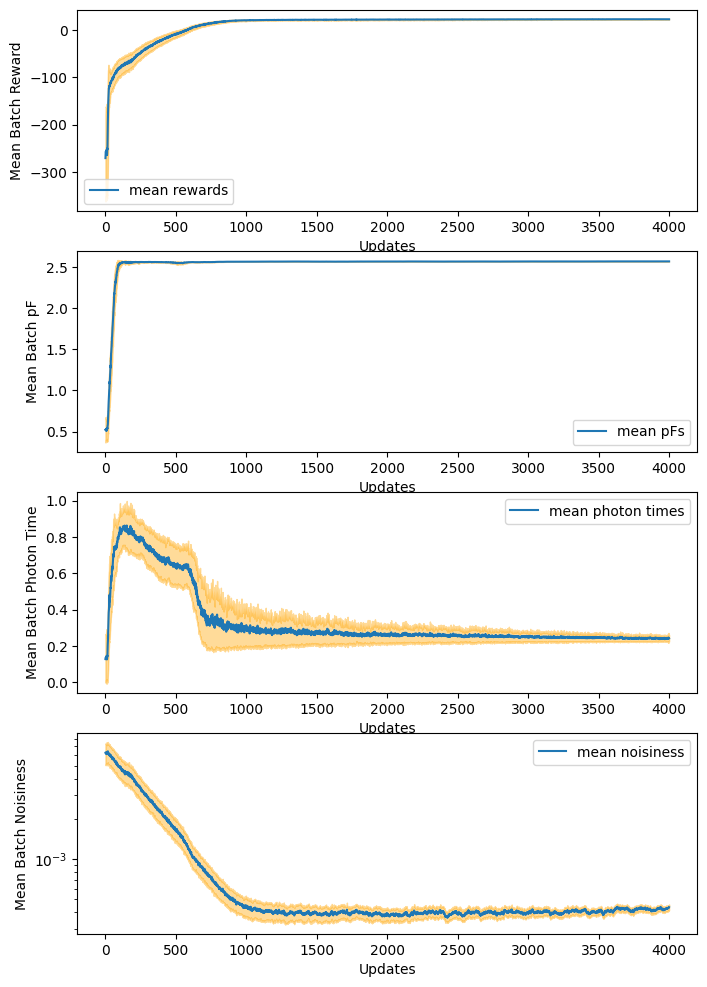

In [13]:
plot_learning(
    rewards=rewards_2,
    max_pFs=max_pFs_2,
    photon_times=photon_times_2,
    smoothnesses=smoothnesses_2,
)

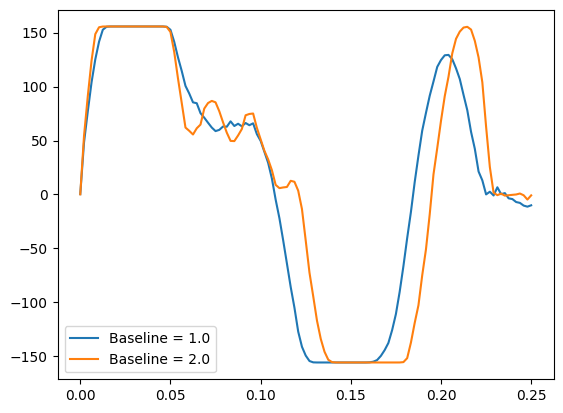

In [14]:
smooth_action_2 = env.prepare_action(-jnp.mean(actions_2, axis=1)[-1])

plt.plot(env.ts_action, smooth_action, label='Baseline = 1.0')
plt.plot(env.ts_action, smooth_action_2, label='Baseline = 2.0')
plt.legend()
plt.show()

## Decreasing Smoothness Baseline (pulses have to be smoother)

In [27]:
single_train_3 = jit(PPO_make_train(config), static_argnums=(-2, -1))

smoothness_baseline_scale_3 = 0.8

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_3 = single_train_3(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    smoothness_baseline_scale_3,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    # batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 4000 Updates
global update: 100
reward: -245.78329838959857
max pF: 2.3324160563376246
max photon: 23.27656363323331
photon time: 0.717930007340541
smoothness: 0.005085538251184936
global update: 200
reward: -192.40801493761387
max pF: 2.5609945213659686
max photon: 41.58215156197548
photon time: 0.8328007404783973
smoothness: 0.0040323593588323416
global update: 300
reward: -148.67722628838715
max pF: 2.5609477399301097
max photon: 40.88429717719555
photon time: 0.8423287606094214
smoothness: 0.003213768210333208
global update: 400
reward: -103.05600229086144
max pF: 2.5629921874715524
max photon: 40.68226258456707
photon time: 0.8567981874246696
smoothness: 0.0023730932885087284
global update: 500
reward: -67.39594485676963
max pF: 2.5626612362640127
max photon: 40.20052559673786
photon time: 0.8691854363561359
smoothness: 0.0017009287037028679
global update: 600
reward: -44.19273655498907
max pF: 2.563276855512018
max photon: 40.76080150902271
photon time: 0.859862

In [28]:
# Extracting Results

metrics_3 = single_result_3["metrics"]

rewards_3 = metrics_3["reward"]
max_pFs_3 = metrics_3["max pF"]
max_photons_3 = metrics_3["max photon"]
photon_times_3 = metrics_3["photon time"]
smoothnesses_3 = metrics_3["smoothness"]
actions_3 = metrics_3["action"]

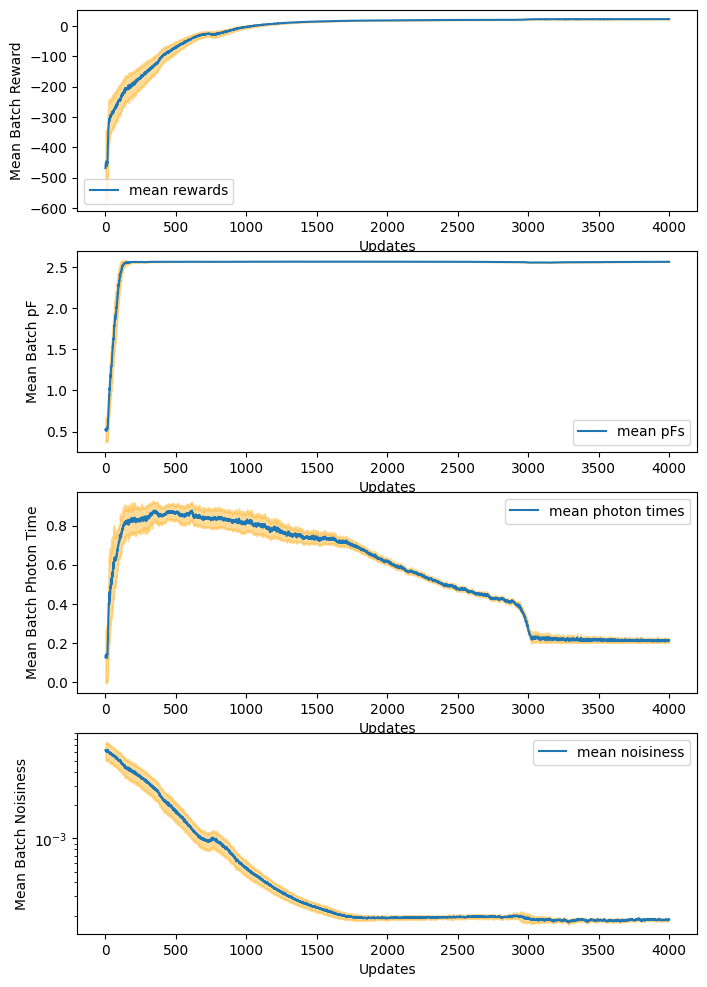

In [29]:
plot_learning(
    rewards=rewards_3,
    max_pFs=max_pFs_3,
    photon_times=photon_times_3,
    smoothnesses=smoothnesses_3,
)

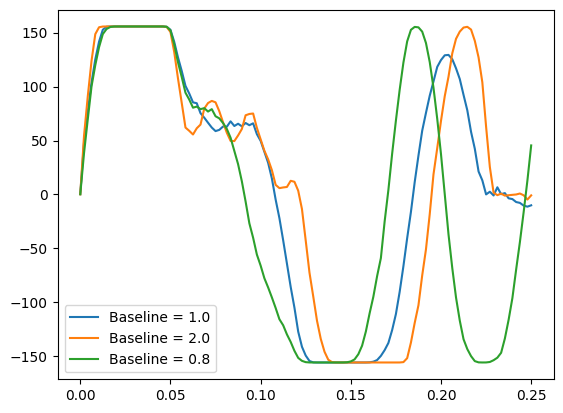

In [32]:
smooth_action_3 = env.prepare_action(-jnp.mean(actions_3, axis=1)[-1])

plt.plot(env.ts_action, smooth_action, label='Baseline = 1.0')
plt.plot(env.ts_action, smooth_action_2, label='Baseline = 2.0')
plt.plot(env.ts_action, smooth_action_3, label='Baseline = 0.8')
plt.legend()
plt.show()

## No Smoothing Constraint (Smoothness Coeff = 0.)

In [33]:
single_train_4 = jit(PPO_make_train(config), static_argnums=(-2, -1))

smoothness_coeff_2 = 0.

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_4 = single_train_4(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff_2,
    smoothness_baseline_scale,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    # batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 4000 Updates


KeyboardInterrupt: 

In [23]:
# Extracting Results

metrics_4 = single_result_4["metrics"]

rewards_4 = metrics_4["reward"]
max_pFs_4 = metrics_4["max pF"]
max_photons_4 = metrics_4["max photon"]
photon_times_4 = metrics_4["photon time"]
smoothnesses_4 = metrics_4["smoothness"]
actions_4 = metrics_4["action"]

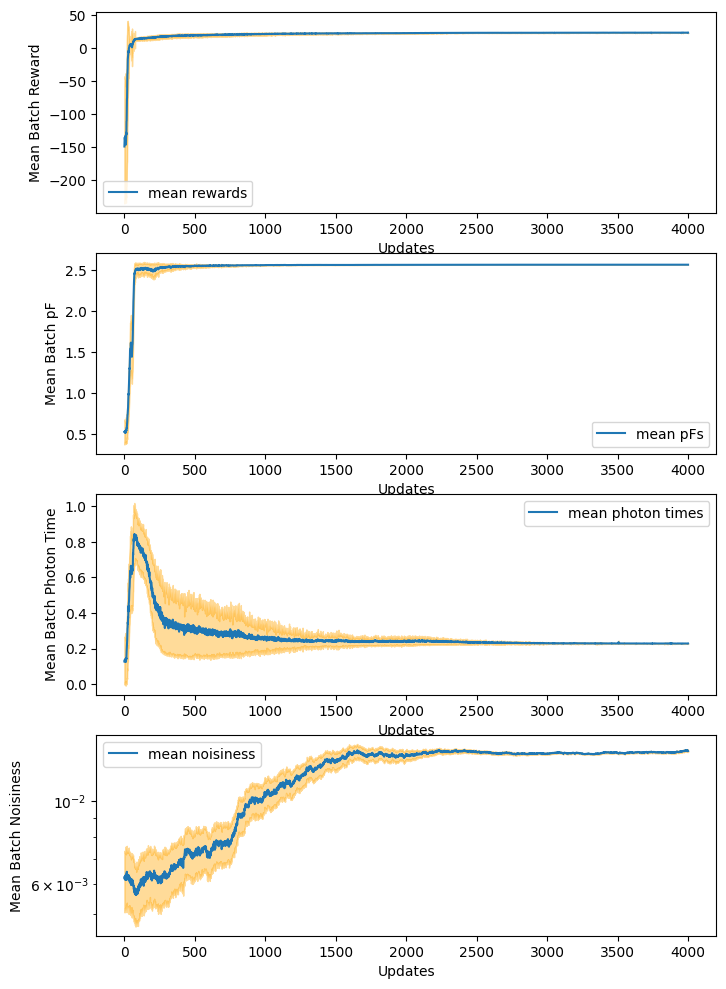

In [24]:
plot_learning(
    rewards=rewards_4,
    max_pFs=max_pFs_4,
    photon_times=photon_times_4,
    smoothnesses=smoothnesses_4,
)

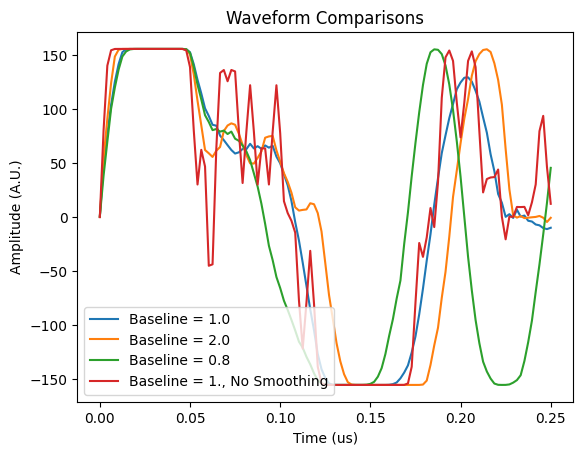

In [36]:
smooth_action_4 = env.prepare_action(-jnp.mean(actions_4, axis=1)[-1])

plt.plot(env.ts_action, smooth_action, label='Baseline = 1.0')
plt.plot(env.ts_action, smooth_action_2, label='Baseline = 2.0')
plt.plot(env.ts_action, smooth_action_3, label='Baseline = 0.8')
plt.plot(env.ts_action, smooth_action_4, label='Baseline = 1., No Smoothing')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.title('Waveform Comparisons')
plt.legend()
plt.show()

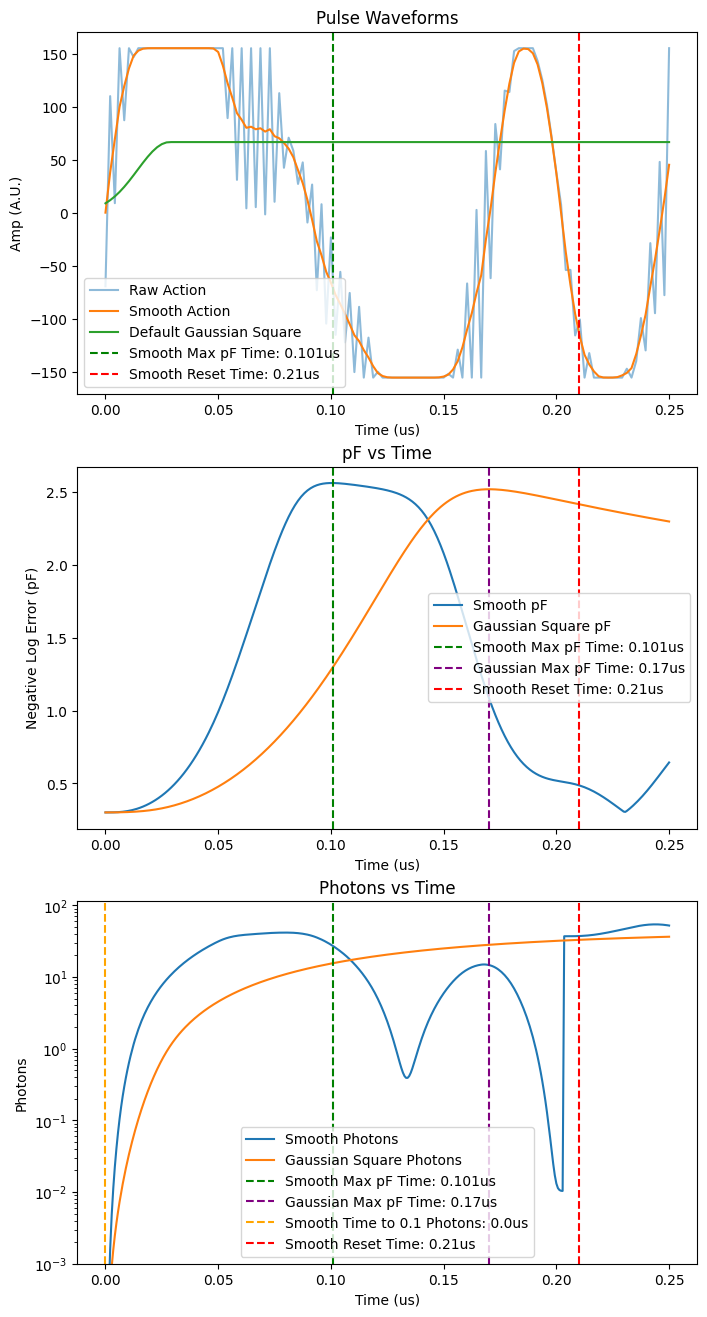

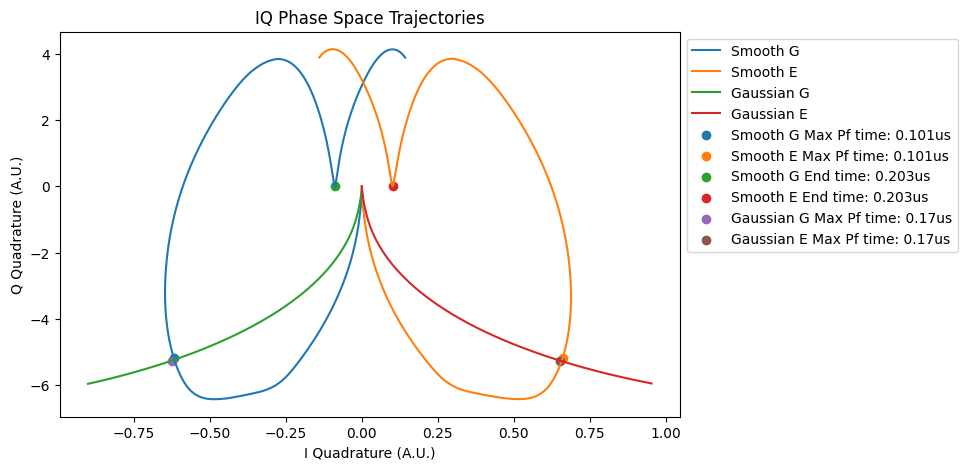

In [38]:
env.rollout_action(-jnp.mean(actions_3, axis=1)[-1], photon_log_scale=True)

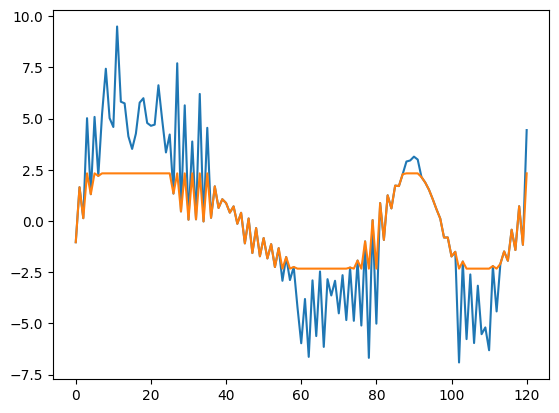

In [41]:
raw_action = -jnp.mean(actions_3, axis=1)[-1]
plt.plot(raw_action)
plt.plot(jnp.clip(raw_action, a_min=-env.mu, a_max=env.mu))